In [1]:
import torch
import pandas as pd
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from data_treatment import DataSet, DataAtts
from discriminator import *
from generator import *
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import glob

In [2]:
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): 
        return n.cuda() 
    return n

In [3]:
files_dropdown = widgets.Dropdown(
    options=glob.glob("original_data/*.csv"),
    description='File:',
    value = 'original_data/diabetes.csv',
    disabled=False,
)
display(files_dropdown)

Dropdown(description='File:', index=1, options=('original_data/data.csv', 'original_data/diabetes.csv'), value…

In [4]:
file_name=files_dropdown.value
dataAtts = DataAtts(file_name)


In [5]:
def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [6]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [7]:
lr = 0.0002
#lr= 0.0002
d_steps = 1
batch_size = 5
num_epochs = 1000
print_interval = 100
num_test_samples = 16
loss = nn.BCELoss()

In [8]:
discriminator = DiscriminatorNet(dataAtts.class_len)
generator = GeneratorNet(dataAtts.class_len)
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

In [9]:
d_error_plt = [0]
g_error_plt = [0]

generated_points = []

In [10]:

test_noise = noise(num_test_samples)
database = DataSet (csv_file=file_name, root_dir=".")

data_loader = torch.utils.data.DataLoader(database, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

In [11]:
for epoch in range(num_epochs):
    print("Epoch ", epoch)

    for n_batch, real_batch in enumerate(data_loader):
        # 1. Train Discriminator
        real_data = Variable(real_batch).float()
        if torch.cuda.is_available(): 
            real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        generated_points.append(fake_data)
        # Train G
        g_error = train_generator(g_optimizer, fake_data)

        # Display Progress

        #if (n_batch) % print_interval == 0:
    filename = "results/" + dataAtts.fname + "/" + str(epoch) + "_" + str(n_batch) + ".txt"
    print(filename)
    file = open(filename, "w")
    print("Discriminator error: ", d_error)
    print("Generator error: ", g_error)
    print("")

    file.write("Discriminator error: " + str(d_error) + "\n")
    file.write("Generator error: " + str(g_error) + "\n")
    file.write("Points: " + str(fake_data) + "\n\n\n")

    d_error_plt.append(d_error)
    g_error_plt.append(g_error)
        #     #display.clear_output(True)
        #     # Display Images
        #     test_images = generator(test_noise).data.cpu()
        #     logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
        #     # Display status Logs
        #     #logger.display_status(epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake)
        # # Model Checkpoints


Epoch  0
results/diabetes/0_153.txt
Discriminator error:  tensor(0.5570, grad_fn=<ThAddBackward>)
Generator error:  tensor(1.5897, grad_fn=<BinaryCrossEntropyBackward>)

Epoch  1
results/diabetes/1_153.txt
Discriminator error:  tensor(3.3539, grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6688, grad_fn=<BinaryCrossEntropyBackward>)

Epoch  2
results/diabetes/2_153.txt
Discriminator error:  tensor(0.6778, grad_fn=<ThAddBackward>)
Generator error:  tensor(1.0888, grad_fn=<BinaryCrossEntropyBackward>)

Epoch  3


KeyboardInterrupt: 

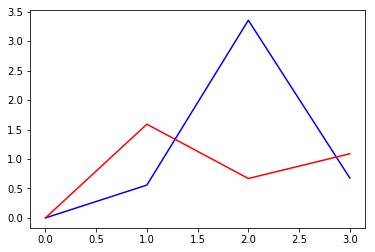

<Figure size 432x288 with 0 Axes>

In [13]:
plt.plot(d_error_plt, 'b')
plt.plot(g_error_plt, 'r')
filename = "results/" + dataAtts.fname + "/" + "error_growth.txt"
file = open(filename, "w")
file.write("Discriminator error: " + str(d_error_plt) + "\n")
file.write("\n\n\n")
file.write("Generator error: " + str(g_error_plt) + "\n")
file.close()

plt.savefig('images/'+ dataAtts.fname + "/"+ 'error.png')
plt.show()
plt.clf()

In [16]:
points_collection = []
for batch in generated_points:
    if batch[0].size() != []:
        for point in batch:
            point = point.cpu().detach().numpy()
            points_collection.append(point)
df = pd.DataFrame(points_collection, columns=database.get_columns()).round(2)
df.to_csv( "fake_data/" + dataAtts.fname + "_" + str(epoch) + ".csv")

In [18]:
torch.save(discriminator.state_dict(), "models/" + dataAtts.fname + "_" + str(epoch) + "_discriminator.pt")
torch.save(generator.state_dict(), "models/" + dataAtts.fname + "_" + str(epoch) + "generator.pt")